In [1]:
import toml
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlalchemy as sa
import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sns.set_theme()
mpl.rcParams["text.usetex"] = False

In [2]:
config = toml.load("./db.toml")['psql']
connection_string = f"postgresql://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

In [3]:
conn = sa.create_engine(connection_string)

In [4]:
def cdf(series: pd.Series) -> pd.DataFrame:
    """ calculates the cumulative distribution function of the given series"""
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [5]:
sns.set_theme()
dpi = 150

In [6]:
date_min = "2023-03-06"
date_max = "2023-03-13"

In [7]:
query = f"""
SELECT
    n.region,
    r.duration,
    r.created_at,
    DATE(r.created_at)::TEXT date
FROM retrievals r
    INNER JOIN nodes n ON r.node_id = n.id
WHERE r.created_at >= '{date_min}'
  AND r.created_at < '{date_max}'
ORDER BY r.created_at
"""
retrievals = pd.read_sql_query(query, con=conn)
retrievals

,region,duration,created_at,date
0,eu-central-1,0.111972,2023-03-06 00:00:28.751845+00:00,2023-03-06
1,us-west-1,0.386354,2023-03-06 00:00:28.910442+00:00,2023-03-06
2,ap-south-1,1.078204,2023-03-06 00:00:30.088840+00:00,2023-03-06
3,ap-southeast-2,1.043488,2023-03-06 00:00:30.110689+00:00,2023-03-06
4,af-south-1,1.862780,2023-03-06 00:00:31.050360+00:00,2023-03-06
...,...,...,...,...
103811,eu-central-1,0.077215,2023-03-12 23:59:55.342089+00:00,2023-03-12
103812,us-west-1,0.411894,2023-03-12 23:59:55.645949+00:00,2023-03-12
103813,ap-south-1,0.846105,2023-03-12 23:59:56.204955+00:00,2023-03-12
103814,af-south-1,1.005366,2023-03-12 23:59:56.410198+00:00,2023-03-12


In [11]:
query = f"""
SELECT
    n.region,
    p.duration,
    p.created_at,
    DATE(p.created_at)::TEXT date
FROM provides p
    INNER JOIN nodes n ON p.node_id = n.id
WHERE p.created_at >= '{date_min}'
  AND p.created_at < '{date_max}'
ORDER BY p.created_at
"""
provides = pd.read_sql_query(query, con=conn)
provides

,region,duration,created_at,date
0,sa-east-1,122.347621,2023-03-06 00:00:18.270073+00:00,2023-03-06
1,ap-south-1,9.041665,2023-03-06 00:00:40.846833+00:00,2023-03-06
2,ap-southeast-2,4.406370,2023-03-06 00:00:58.252887+00:00,2023-03-06
3,af-south-1,8.134784,2023-03-06 00:01:18.949442+00:00,2023-03-06
4,us-west-1,6.847360,2023-03-06 00:01:37.417741+00:00,2023-03-06
...,...,...,...,...
20768,sa-east-1,5.897879,2023-03-12 23:56:45.297899+00:00,2023-03-12
20769,eu-central-1,34.288504,2023-03-12 23:57:36.081032+00:00,2023-03-12
20770,ap-south-1,21.418332,2023-03-12 23:58:09.333473+00:00,2023-03-12
20771,af-south-1,8.937003,2023-03-12 23:58:30.312250+00:00,2023-03-12


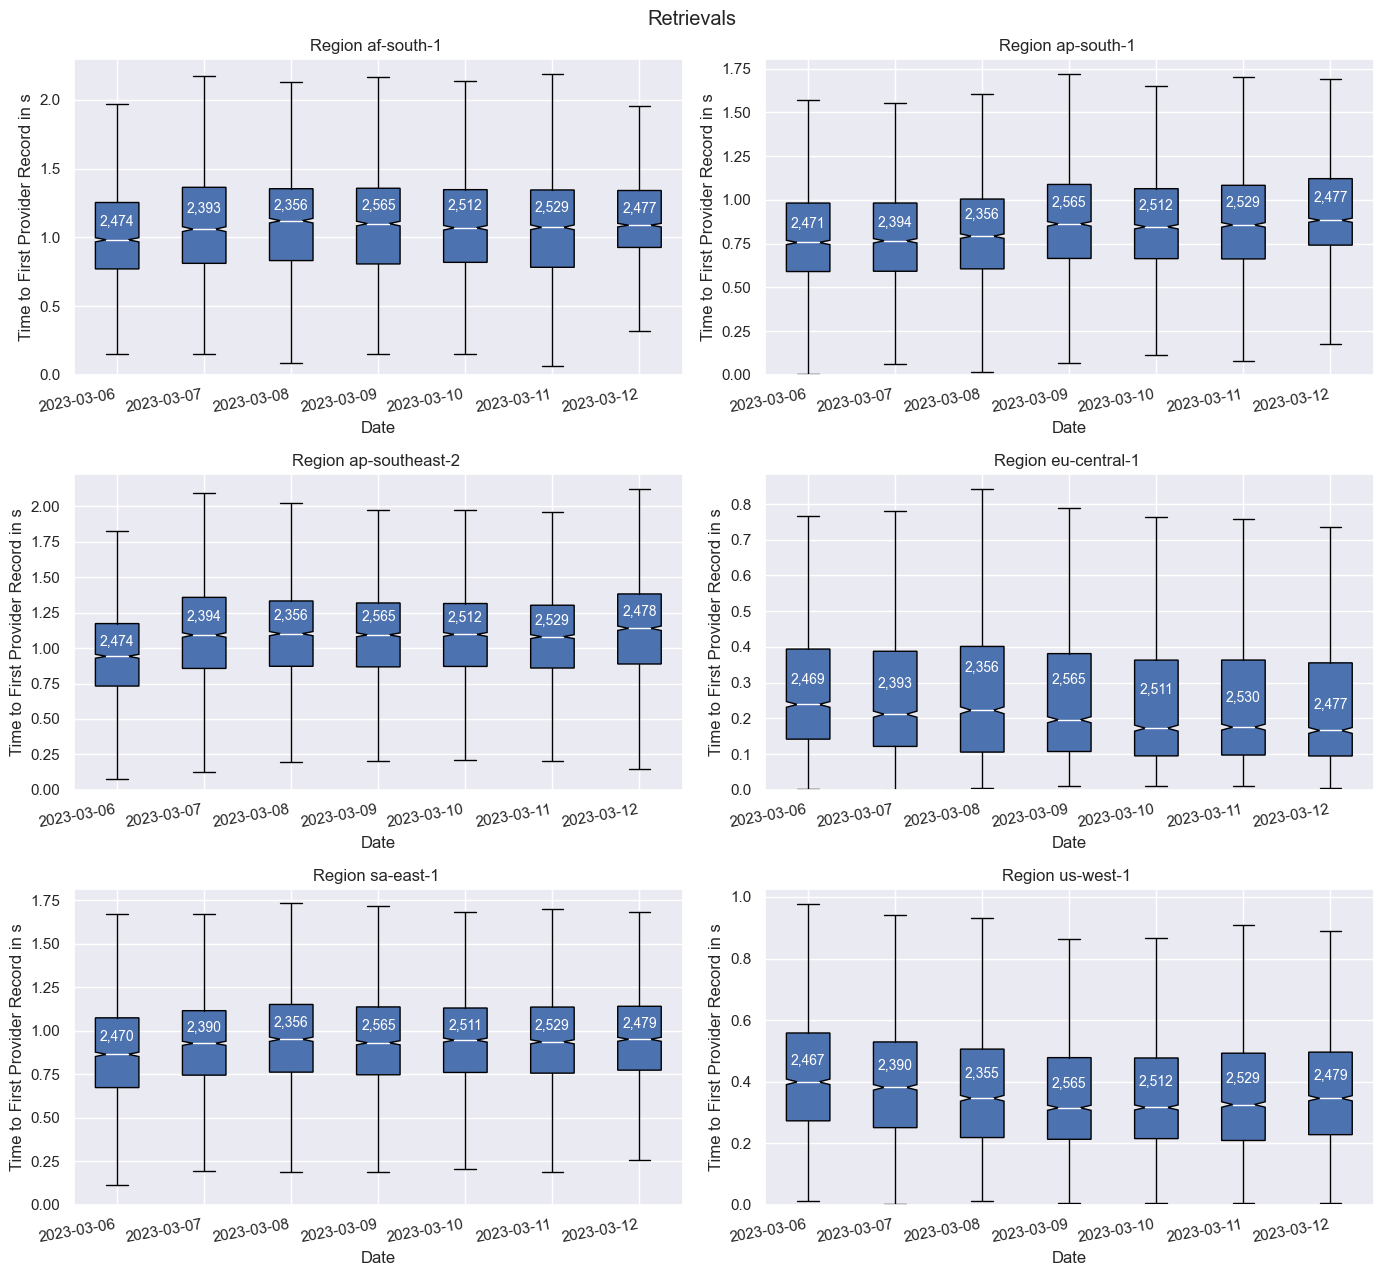

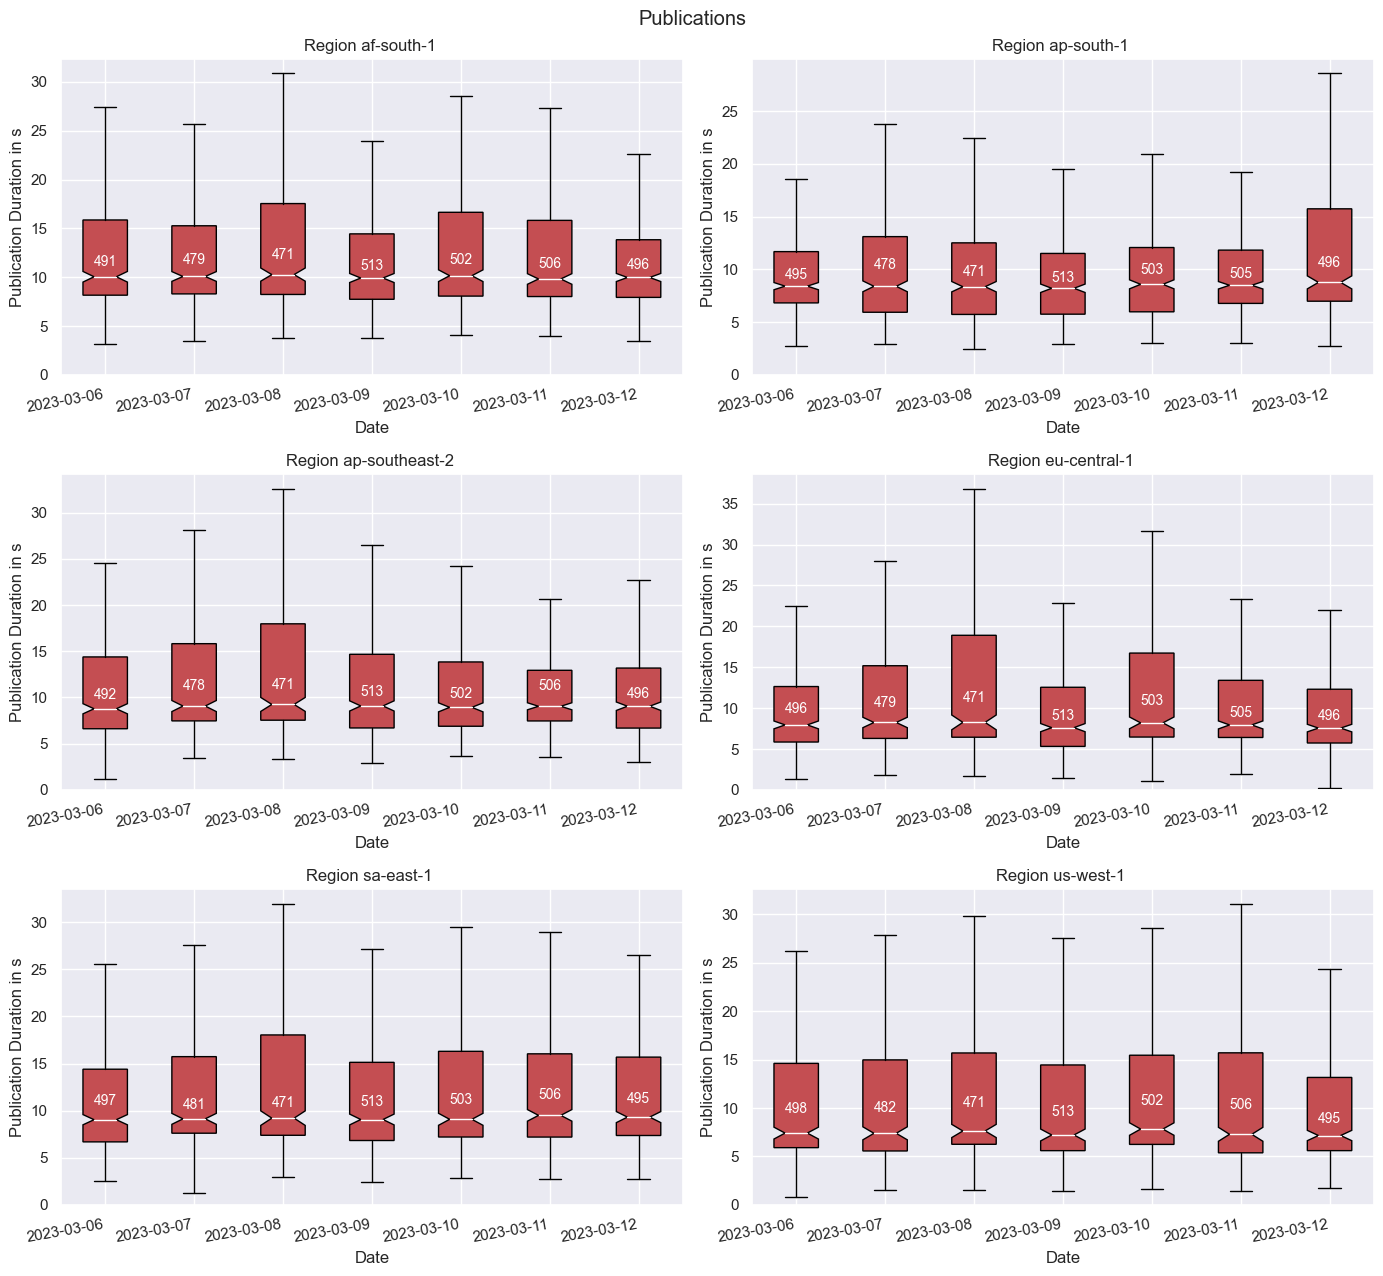

In [18]:
plots = [
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals"
    },
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications"
    },
]

for plot in plots:
    regions = list(sorted(plot["data"]["region"].unique()))

    fig, ax = plt.subplots(len(regions) // 2 + len(regions) % 2, 2, figsize=[14, 13])

    for i, region in enumerate(regions):
        ax = fig.axes[i]

        group = plot["data"][plot["data"]["region"] == region].groupby('date')
        data = group['duration'].apply(list)

        bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

        for box in bplot["boxes"]:
            box.set_facecolor(plot["boxcolor"])
        for median in bplot["medians"]:
            median.set_color("white")

        ax.set_xlabel("Date")
        ax.set_title(f"Region {region} ")
        ax.set_ylabel(plot["ylabel"])
        ax.set_ylim(0)

        samples = []
        for j, index in enumerate(data.index):
            y = np.percentile(data.loc[index], 60)
            ax.text(j + 1, y, format(len(data.loc[index]), ","), ha="center", fontdict={"fontsize": 10}, color="w")

        for tick in ax.get_xticklabels():
            tick.set_rotation(10)
            tick.set_ha("right")
    fig.suptitle(plot["title"])
    fig.tight_layout()

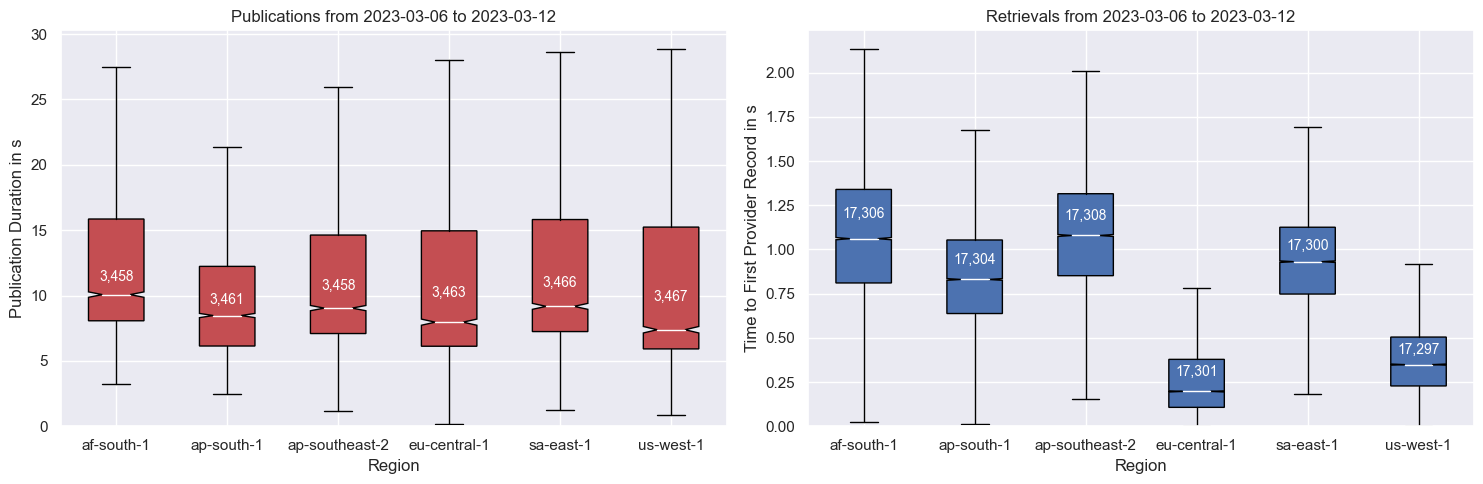

In [28]:
plots = [
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications",
    },
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals",
    },
]

regions = list(sorted(retrievals["region"].unique()))

fig, ax = plt.subplots(1, 2, figsize=[15, 5])

for i, plot in enumerate(plots):
    ax = fig.axes[i]

    group = plot['data'].groupby('region')
    data = group['duration'].apply(list)

    bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

    for box in bplot["boxes"]:
        box.set_facecolor(plot["boxcolor"])

    for median in bplot["medians"]:
        median.set_color("white")

    ax.set_title(f"{plot['title']} from {plot['data']['date'].min()} to {plot['data']['date'].max()}")
    ax.set_xlabel("Region")
    ax.set_ylabel(plot['ylabel'])
    ax.set_ylim(0)

    samples = []
    for j, index in enumerate(data.index):
        y = np.percentile(data.loc[index], 60)
        ax.text(j + 1, y, format(len(data.loc[index]), ","), ha="center", fontdict={"fontsize": 10}, color="w")

fig.tight_layout()

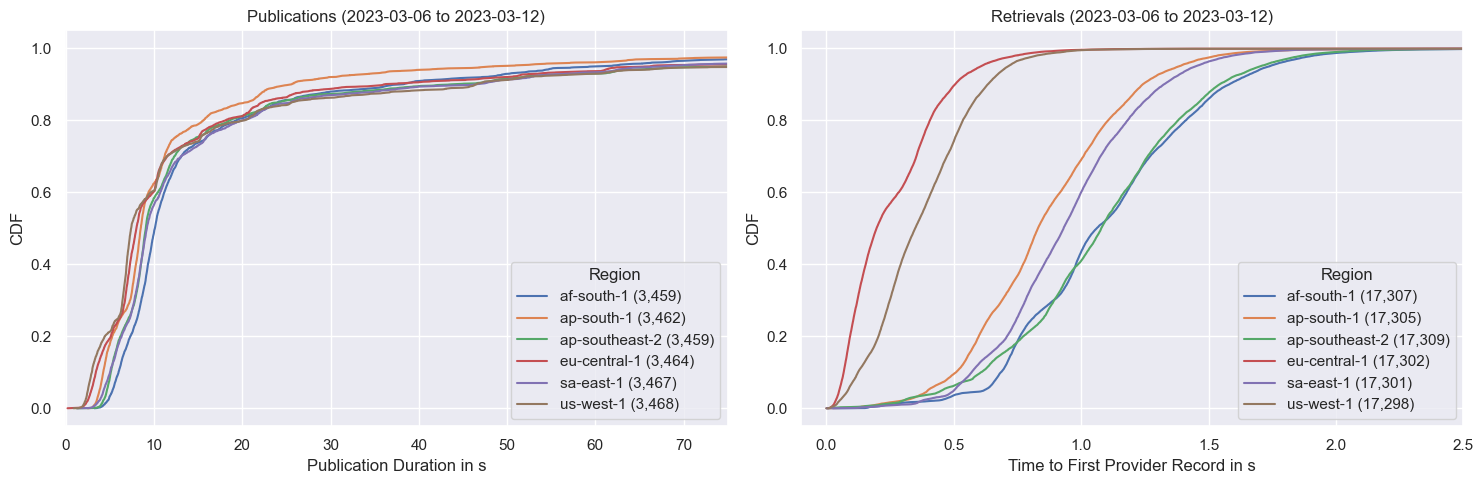

In [27]:
plots = [
    {
        "data": provides,
        "ylabel": "Publication Duration in s",
        "title": "Publications",
        "ymax": 75,
    },
    {
        "data": retrievals,
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals",
        "ymax": 2.5,
    },
]

regions = list(sorted(retrievals["region"].unique()))

fig, ax = plt.subplots(1, 2, figsize=[15, 5])

for i, plot in enumerate(plots):
    ax = fig.axes[i]

    group = plot["data"].groupby('region')
    data = group['duration'].apply(list)

    for j, region in enumerate(sorted(plot["data"]["region"].unique())):
        dat = cdf(pd.Series(data.loc[region], name="duration"))
        ax.plot(dat["duration"], dat["cdf"], label=f"{region} ({format(len(dat), ',')})")

    ax.set_xlim(-0.1, plot["ymax"])
    ax.legend(title="Region")
    ax.set_xlabel(plot["ylabel"])
    ax.set_ylabel("CDF")
    ax.set_title(f"{plot['title']} ({plot['data']['date'].min()} to {plot['data']['date'].max()})")

fig.tight_layout()

In [36]:
query = f"""
SELECT
    n.region,
    r.duration,
    r.rt_size,
    r.error IS NOT NULL has_error
FROM provides r
    INNER JOIN nodes n ON r.node_id = n.id
WHERE r.created_at >= '{date_min}'
  AND r.created_at < '{date_max}'
ORDER BY r.created_at
"""
rt = pd.read_sql_query(query, con=conn)
rt

,region,duration,rt_size,has_error
0,sa-east-1,122.347621,225,False
1,ap-south-1,9.041665,234,False
2,ap-southeast-2,4.406370,232,False
3,af-south-1,8.134784,220,False
4,us-west-1,6.847360,220,False
...,...,...,...,...
20768,sa-east-1,5.897879,206,False
20769,eu-central-1,34.288504,210,False
20770,ap-south-1,21.418332,213,False
20771,af-south-1,8.937003,206,False


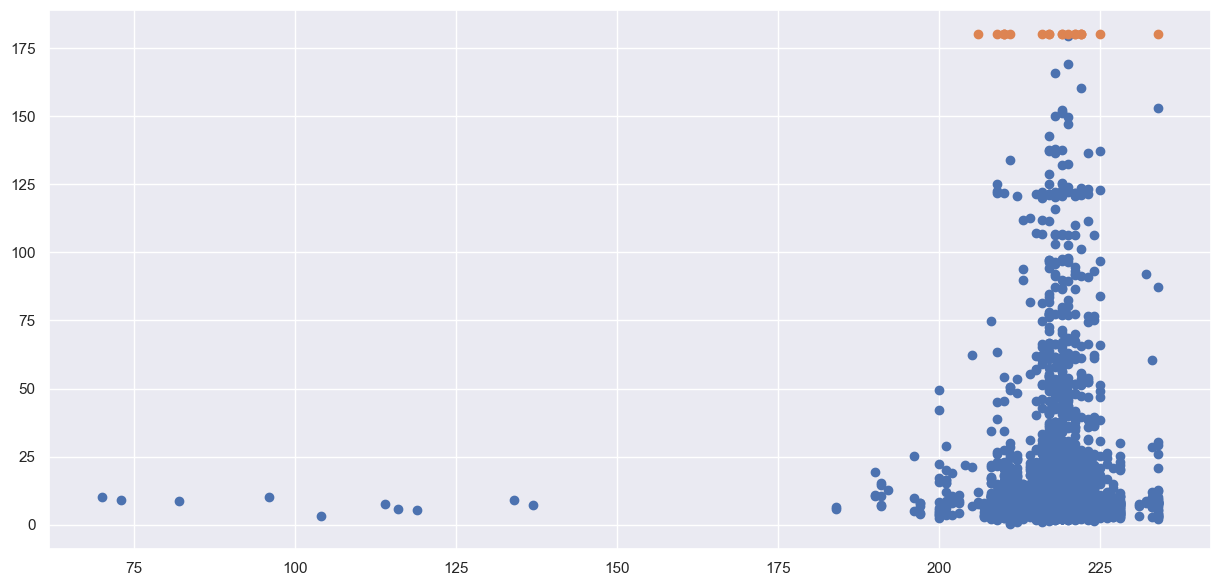

In [37]:
fig, ax = plt.subplots(figsize=[15, 7])
dat = rt[rt["region"] == "eu-central-1"]


dat2= dat[dat["has_error"] == False]
ax.scatter(dat2["rt_size"], dat2["duration"])

dat2= dat[dat["has_error"]== True]
ax.scatter(dat2["rt_size"], dat2["duration"])